# -----------------------------------------------------------------------------------------
# 1. Setup
# -----------------------------------------------------------------------------------------

#### Import Packages

In [1]:
# general packages
import pandas as pd
import os

#### Import Functions

In [2]:
# Load the autoreload extension
%load_ext autoreload
%autoreload 1

# Import functions for scraping the data
%aimport get_data
import get_data as gd

# Import functions for analysing the data
%aimport analyse_portfolio
import analyse_portfolio as ap

#### Configure Notebook

In [3]:
# Update the default number of rows that are displayed
pd.set_option('display.max_rows', 500)

# disable chained assignments
pd.options.mode.chained_assignment = None

#### Define the Variables Specific to Our User

In [10]:
username = "user2"

In [11]:
users_email, base_currency = {"user1": (os.environ.get("MY_EMAIL_ADDRESS"), "EUR"),
                              "user2": (os.environ.get("MY_EMAIL_ADDRESS"), "EUR"),
                             }[username]

# -----------------------------------------------------------------------------------------
# 2. Update Database Files
# -----------------------------------------------------------------------------------------

#### Scrape Company Ticker *->* Company Name Data

In [4]:
gd.create_company_ticker_to_name_map()

#### Scrape Exchange Ticker *->* Exchange Name Data

In [5]:
gd.create_exchange_ticker_to_name_map()

#### Scrape Historic Stock Prices & Dividends Recieved For Each Stock

In [6]:
# Get List of Unique Tickers & Unique Currencies
ticker_date_map, currency_list = gd.extract_unique_stock_and_currency_values_from_all_transactions()

In [7]:
gd.create_table_of_historic_stock_prices(ticker_date_map) #unique_tickers_list, ticker_start_date_list)

- SVE: No data found for this date range, symbol may be delisted
SVE not found
- NOVR: No data found, symbol may be delisted
NOVR not found
- MMG: No data found for this date range, symbol may be delisted
MMG not found
- RSLV: No data found, symbol may be delisted
RSLV not found
- LGD: No data found for this date range, symbol may be delisted
LGD not found
- SSV: No data found for this date range, symbol may be delisted
SSV not found
- ELEC: No data found for this date range, symbol may be delisted
ELEC not found


#### Scrape Historic Exchange Rates

In [8]:
# Get min date across all transactions
currency_start_date = min(ticker_date_map.values())

In [12]:
gd.create_exchange_rate_to_date_map(base_currency, currency_list, currency_start_date)

# -----------------------------------------------------------------------------------------
# 3. Read in Users Transaction Data
# -----------------------------------------------------------------------------------------

#### Read in Manually Populated Transactions Table

In [13]:
raw_transactions = gd.read_in_raw_transactions_data(username)

#### Use Scraped Data to Add Columns to Transactions Data

In [14]:
# Add company name
transactions_with_comp_name = gd.create_company_name_col_using_ticker(raw_transactions)

The following stocks did not have an associated company name:
|    | stock_ticker   | exchange_ticker   |
|---:|:---------------|:------------------|
|  6 | LGD            | TOR               |
| 10 | SVE            | TSV               |


In [15]:
# Add Exchange name
transactions_with_exch_name = gd.create_exchange_name_nd_curency_cols_using_ticker(transactions_with_comp_name)

In [16]:
# Add aggregate price columns that track fees, stock prices, bep over time, among others
transactions = gd.add_aggregate_price_columns(transactions_with_exch_name)

# -----------------------------------------------------------------------------------------
# 4. Read in Users Account Balance
# -----------------------------------------------------------------------------------------

#### Read in the Deposite Data

In [17]:
# get the cumulative amount paid into the account broken down by day
daily_amount_in_account_to_date_df = gd.calculate_amount_in_cumulative_account_each_day(username)

#### Calculate the Amount in Account Using the Deposite & Transactions Data

In [18]:
# get the cumulative amount spend on stocks broken down by day
daily_amount_spent_to_date_df = gd.calculate_cumulative_amount_spent_each_day(transactions)

In [19]:
# get the daily cash balance
daily_cash_balance = daily_amount_in_account_to_date_df.sub(daily_amount_spent_to_date_df, fill_value=0)

In [20]:
# Merge these into one table
daily_balance_summary_table = pd.concat([daily_amount_in_account_to_date_df, daily_amount_spent_to_date_df, daily_cash_balance], axis=1).set_axis(["in_account", "spent", "balance"], axis=1)

# -----------------------------------------------------------------------------------------
# 5. Create Stock Valuation Tables
# -----------------------------------------------------------------------------------------

#### Calculate Valuation Table For Each Stock

In [21]:
map_stock_to_valuation_table = ap.create_all_valuation_tables(transactions, base_currency, val_period = "daily")

Error retrieving stock price for ticker: 'LGD' (TOR). No valuation table calculated for this stock!


Error retrieving stock price for ticker: 'SVE' (TSV). No valuation table calculated for this stock!


#### Create a Table of the Users Portfolio on Specific Date

In [22]:
selected_date = "2021-10-16"

In [23]:
portfolio_df_on_date = ap.get_portflio_on_date(map_stock_to_valuation_table, selected_date)

Analysing portfolio for yesterday - 2021-10-16


In [24]:
# Format this table
formatted_portfolio_df = ap.format_portfolio_df(portfolio_df_on_date, base_currency)

# -----------------------------------------------------------------------------------------
# 6. Visualise Portfolio
# -----------------------------------------------------------------------------------------

#### Plot Stock Prices of Users Stocks

Cannot create plot for 'LGD (TOR)' as it is not in the scraped stock price data
Cannot create plot for 'SVE (TSV)' as it is not in the scraped stock price data


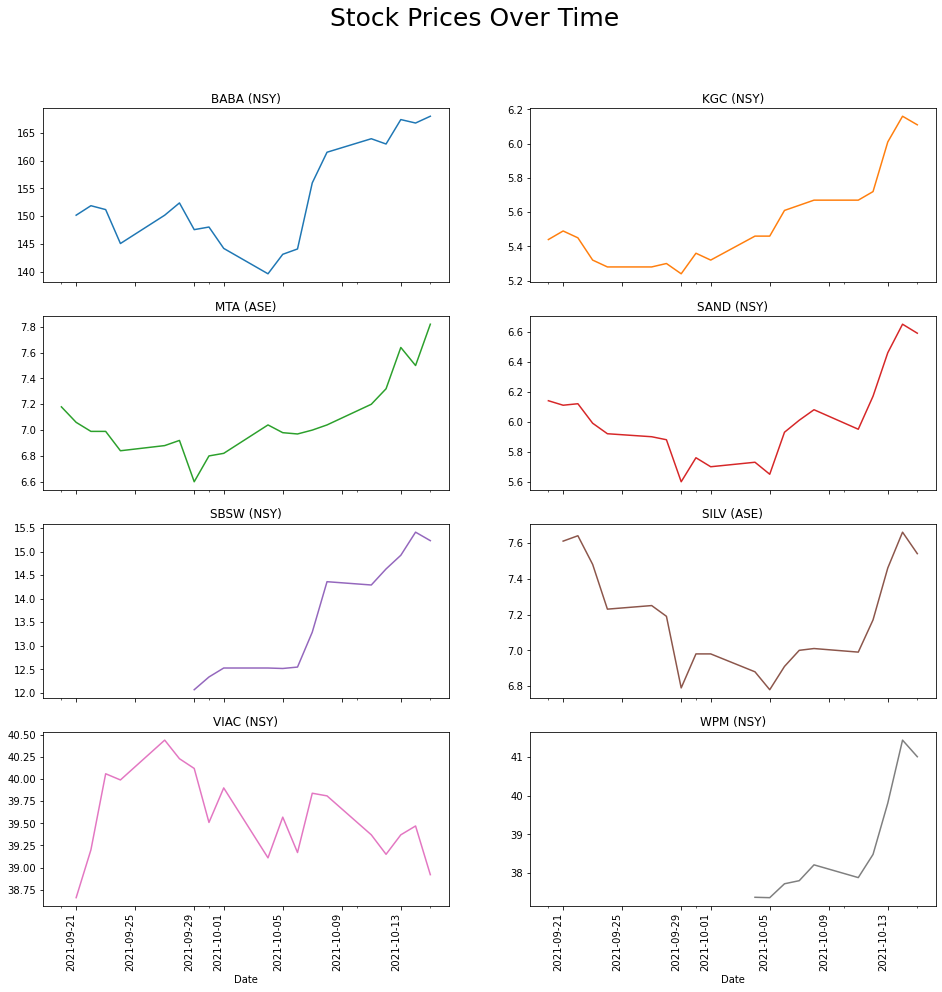

In [25]:
ap.plot_stock_prices(transactions)

#### Plot Currency Exchange Rates of Currencies Users Stocks are in

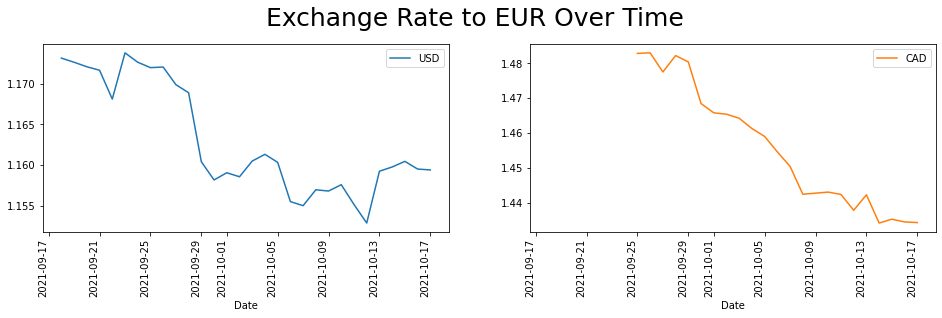

In [27]:
ap.plot_exchange_rates(transactions, base_currency)

#### Visualise Stock Performance Over Time

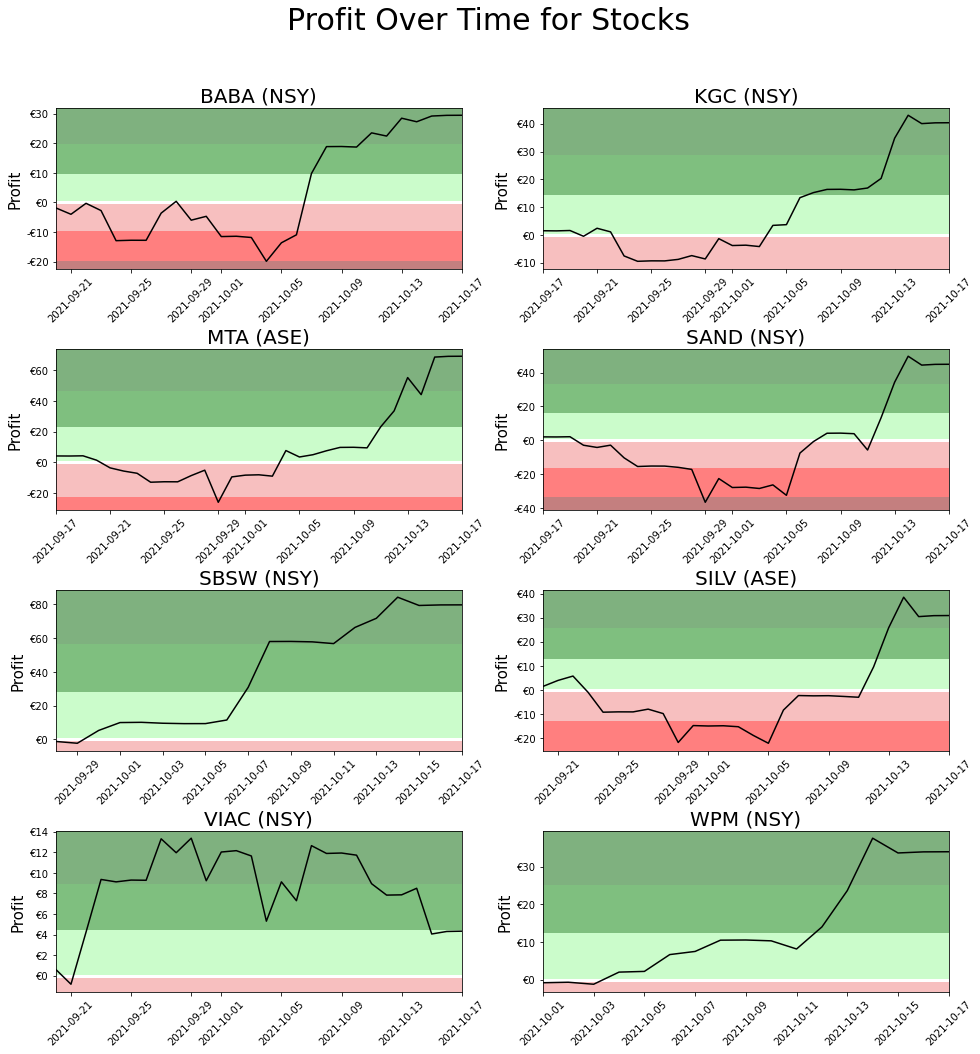

In [33]:
ap.visualise_profit_over_time(map_stock_to_valuation_table)

#### Visualise Portfolio Breakdown on Specific Date

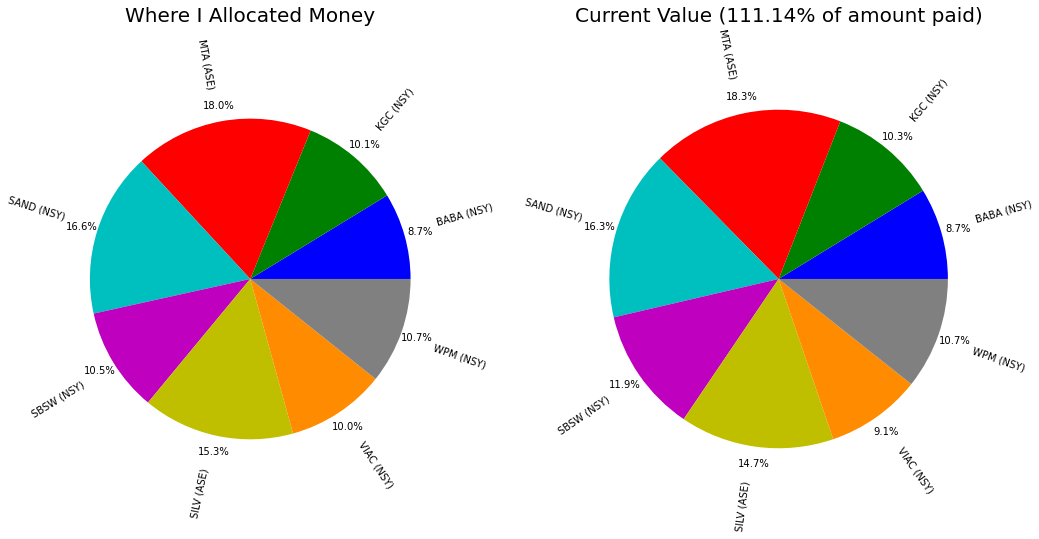

In [30]:
ap.visualise_portfolio_pie_chart(portfolio_df_on_date, base_currency)

# -----------------------------------------------------------------------------------------
# 7. Send Email With Portfolio Update
# -----------------------------------------------------------------------------------------

In [175]:
ap.send_portfolio_update_from_gmail_account(username, users_email, formatted_portfolio_df)

'Email Sent Successfully'